### Example for training and analyzing an RNN for sentiment classification.

Author: Niru Maheswaranathan

Date: July 27, 2020

This notebook walks through training a recurrent neural network (in this case, a GRU) on sentiment classification using the IMDB reviews dataset. Then, we will analyze the GRU using fixed point analyses, and show how it uses line attractor dynamics to solve the task.

See [Maheswaranathan et al 2019](http://papers.nips.cc/paper/9700-reverse-engineering-recurrent-networks-for-sentiment-classification-reveals-line-attractor-dynamics) and [Maheswaranathan & Sussillo 2020](https://arxiv.org/abs/2004.08013) for more information.

### Imports

In [1]:
# renn, or "reverse engineering neural networks", contains the code we will use
# to train & analyze the network.
!pip install renn

In [2]:
# Additional imports

import functools

import jax
import jax.numpy as jnp
from jax.experimental import optimizers
from jax.experimental import stax

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

from tqdm.notebook import tqdm

import renn

## Train the network.

### Load IMDB reviews data

In [3]:
def load_data(sequence_length, batch_size):
    dset_name = "imdb_reviews/subwords8k"
    
    # Load raw datasets
    datasets, info = tfds.load(dset_name, with_info=True)
    encoder = info.features['text'].encoder
    
    def pipeline(dset):
        """Data preprocessing pipeline."""
        
        # Truncates examples longer than the sequence length.
        dset = dset.filter(lambda d: len(d['text']) <= sequence_length)
        
        # Extracts features and targets
        def _extract(d):
            return {
                'inputs': d['text'],
                'labels': d['label'],
                'index': len(d['text']),
            }
        dset = dset.map(_extract)
        
        # Cache and shuffle.
        dset = dset.cache().shuffle(buffer_size=1024, seed=0)
        
        # Pad.
        padded_shapes = {
            'inputs': (sequence_length,),
            'labels': (),
            'index': (),
        }
        dset = dset.padded_batch(batch_size, padded_shapes)
        return dset
    
    train_dset = pipeline(datasets['train'])
    test_dset = pipeline(datasets['test'])
    
    return encoder, info, train_dset, test_dset

In [4]:
# Dataset parameters.
max_pad = 1500
batch_size = 64

# Here we load both the text encoder, training dataset, and test dataset.
encoder, info, train_dset, test_dset = load_data(max_pad, batch_size)

# Load a batch of data.
batch = next(tfds.as_numpy(train_dset))

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteK91B2R/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteK91B2R/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteK91B2R/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


### Build RNN and train step function

In [5]:
def build_rnn(vocab_size, emb_size, num_units):
  """Builds a single layer RNN."""

  # Build the embedding layer.
  emb_init, emb_apply = renn.rnn.cells.embedding(vocab_size, emb_size)

  # Build the RNN cell.
  num_outputs = 1   # Logistic regression only needs a single output unit.
  cell = renn.rnn.cells.GRU(num_units)
  readout_init, readout_apply = stax.Dense(num_outputs)

  def init_fun(prng_key, input_shape):
    """Initializes the network (the embedding and the RNN cell)."""
    k0, k1, k2 = jax.random.split(prng_key, 3)
    emb_shape, emb_params = emb_init(k0, input_shape)
    output_shape, rnn_params = cell.init(k1, emb_shape[1:])
    _, readout_params = readout_init(k2, output_shape)

    # We explicitly add the batch dimension back in.
    # (This is because we only applied `vmap` to the rnn_apply function above)
    batch_output_shape = (emb_shape[0],) + output_shape

    return batch_output_shape, (emb_params, rnn_params, readout_params)

  def apply_fun(params, inputs):
    """Applies the RNN."""
    # Destructure parameter tuple.
    emb_params, rnn_params, readout_params = params

    # [batch, len, dim]
    emb_inputs = emb_apply(emb_params, inputs)
    initial_states = cell.get_initial_state(
        rnn_params, batch_size=emb_inputs.shape[0])

    batch_apply = functools.partial(cell.batch_apply, rnn_params)
    all_logits = renn.rnn.unroll.unroll_rnn(
        initial_states, emb_inputs, batch_apply,
        functools.partial(readout_apply, readout_params))

    return all_logits

  def mask_fun(sequences, last_index):
    """Selects the last valid timestep from a batch of padded sequences."""
    last_index = last_index[:, jnp.newaxis, jnp.newaxis]
    return jnp.squeeze(jnp.take_along_axis(sequences, last_index, axis=1))

  def sigmoid_xent_with_logits(logits, labels):
    return jnp.maximum(logits, 0) - logits * labels + \
        jnp.log(1 + jnp.exp(-jnp.abs(logits)))

  def loss_fun(params, batch):
    """Cross-entropy loss function."""
    all_logits = apply_fun(params, batch['inputs'])
    logits = mask_fun(all_logits, batch['index'])
    losses = sigmoid_xent_with_logits(logits, batch['labels'])

    # Average over the batch and convert from nats to bits.
    return jnp.mean(losses) / jnp.log(2.)

  @jax.jit
  def accuracy_fun(params, batch):
    all_logits = apply_fun(params, batch['inputs'])
    logits = mask_fun(all_logits, batch['index'])
    predictions = (logits >= 0.).astype(jnp.int32)
    return batch['labels'] == predictions

  return init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun


def build_optimizer_step(optimizer, initial_params, loss_fun):
  """Builds training step function."""

  # Destructure the optimizer triple.
  init_opt, update_opt, get_params = optimizer
  opt_state = init_opt(initial_params)

  @jax.jit
  def optimizer_step(current_step, state, batch):
    """Takes a single optimization step."""
    p = get_params(state)
    loss, gradients = jax.value_and_grad(loss_fun)(p, batch)
    new_state = update_opt(current_step, gradients, state)
    return current_step + 1, new_state, loss

  return opt_state, optimizer_step

In [6]:
# RNN parameters.
emb_size = 128
num_units = 256
prng_key = jax.random.PRNGKey(0)

# This function builds our RNN classifier. It is a single layer GRU, with a linear readout.
init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun = build_rnn(encoder.vocab_size, emb_size, num_units)
output_shape, initial_params = init_fun(prng_key, batch['inputs'].shape)

In [7]:
# Optimizer parameters.
learning_rate = optimizers.exponential_decay(1e-3, 1000, 0.2)
opt = optimizers.adam(learning_rate)

# Functions to train the RNN.
opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun)
global_step = 0
train_losses = []

### Run training loop.

In [8]:
num_examples = info.splits['train'].num_examples
num_batches = num_examples // batch_size

def test_accuracy(params):
  _accs = []
  for batch in tqdm(tfds.as_numpy(test_dset), total=num_batches):
    _accs += accuracy_fun(params, batch)
  return np.mean(_accs)
  
for epoch in range(4):

  # Training epoch.
  for batch in tqdm(tfds.as_numpy(train_dset), total=num_batches):
    global_step, opt_state, loss = step_fun(global_step, opt_state, batch)
    train_losses.append(loss)
  
  # Testing epoch.
  test_acc = test_accuracy(opt[2](opt_state))
  print(f'[Epoch {epoch+1:02d}] Test Acc: {100 * test_acc:03f}')


[Epoch 01] Test Acc: 81.448600



[Epoch 02] Test Acc: 84.373117



[Epoch 03] Test Acc: 85.401518



[Epoch 04] Test Acc: 85.397501


In [9]:
# Destructure the trained parameters of the RNN.
#   emb_params: The parameters of the embedding layer.
#   rnn_params: The parameters of the RNN (GRU). 
#   readout_params: The parameters of the final readout layer.
final_params = opt[2](opt_state)
emb_params, rnn_params, readout_params = final_params

## Analyze the network.

### Get RNN hidden states visited during test examples.

We will need a collection of the hidden states visited by the RNN for both visualization purposes (we will use them to find a low-dimensional projection for visualization) and for seeding the numerical procedure to find approximate fixed points of the RNN dynamics.

In [10]:
from sklearn.decomposition import PCA

In [11]:
# Here, we build some helper functions to collect RNN hidden states.

emb_init, emb_apply = renn.embedding(encoder.vocab_size, emb_size)
cell = renn.GRU(num_units)

@jax.jit
def _get_all_states(inputs):
  """Get RNN states in response to a batch of inputs (also returns masked states)."""
  rnn_inputs = emb_apply(emb_params, inputs)
  initial_states = cell.get_initial_state(rnn_params, batch_size=rnn_inputs.shape[0])
  return renn.unroll_rnn(initial_states, rnn_inputs, functools.partial(cell.batch_apply, rnn_params))

def rnn_states(batch):
  """Return (masked) RNN states."""
  states = _get_all_states(batch['inputs'])
  return [h[:idx] for h, idx in zip(states, batch['index'])]

In [12]:
# Get RNN hidden states in response to a test batch.
test_batch = next(tfds.as_numpy(test_dset))

hs = rnn_states(test_batch)
pts = np.vstack(hs)[::2]
pts.shape

(10289, 256)

In [17]:
# Group these states by the corresponding label.
pos_states = [h for h, lbl in zip(hs, test_batch['labels']) if lbl == 1]
neg_states = [h for h, lbl in zip(hs, test_batch['labels']) if lbl == 0]

In [18]:
# We use principal components analysis (PCA) for visualization.
pca = PCA(n_components=2).fit(pts)

In [19]:
# The initial state.
h0 = cell.get_initial_state(rnn_params)
h0.shape

(256,)

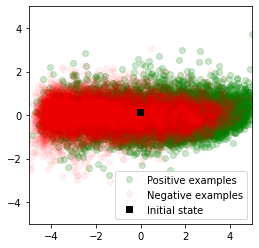

In [20]:
# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

plt.figure(figsize=(4, 4))

x, y = pca.transform(np.vstack(pos_states)).T
plt.plot(x, y, 'go', alpha=0.2, label='Positive examples')

x, y = pca.transform(np.vstack(neg_states)).T
plt.plot(x, y, 'ro', alpha=0.05, label='Negative examples')

x0, y0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(x0, y0, 'ks', label='Initial state')

plt.xlim(-5, 5)
plt.ylim(-5, 5)

plt.legend()

### Fixed point analysis

Next, we analyze the dynamics of the RNN using approximate fixed points.

First, we need to numerically find approximate fixed points of the dynamics.
We do this by setting up a simple optimization procedure.

In [21]:
fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)

In [30]:
fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, pts,
                                                            jnp.zeros((pts.shape[0], 128)),
                                                            optimizers.adam(0.01),
                                                            tolerance=5e-5)

  6%|▌         | 582/10000 [00:03<00:49, 190.20it/s]


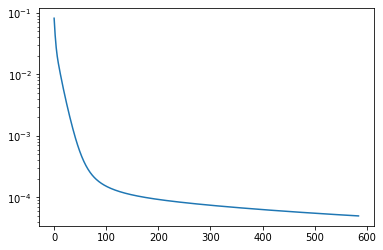

In [31]:
plt.semilogy(loss_hist)

Text(0, 0.5, 'Projection onto principal component #2')

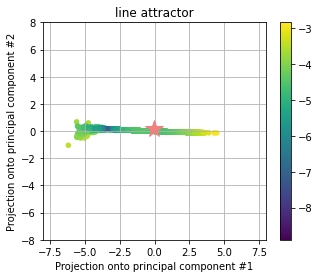

In [33]:
# Visualization of the approximate fixed points: the line attractor.

plt.figure(figsize=(5, 4))
x, y = pca.transform(fixed_points).T
plt.scatter(x, y, s=20, c=np.log10(fp_losses))
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.grid()

plt.plot(x0, y0, '*', color='lightcoral', ms=18)
plt.title('line attractor')

plt.colorbar()

plt.xlabel('Projection onto principal component #1')
plt.ylabel('Projection onto principal component #2')

### Jacobian analysis

Now that we have approximate fixed points, we will analyze their dynamics by studying the corresponding Jacobian.

In [34]:
# Pick a fixed point.
fp_idx = np.argmin(fp_losses)
fp = fixed_points[fp_idx]

In [36]:
# Computes the recurrent Jacobian.
jac = jax.device_get(cell.rec_jac(rnn_params, jnp.zeros(128), fp))

# Perform an eigendecomposition to get eigenvectors and eigenvalues.
R, E, L = renn.eigsorted(jac)

Text(0, 0.5, 'imag')

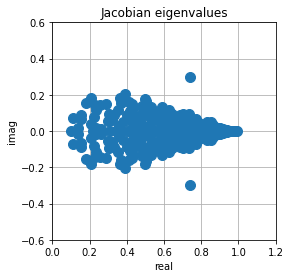

In [37]:
plt.figure(figsize=(4, 4))
plt.plot(np.real(E), np.imag(E), 'o', ms=10)
plt.grid()
plt.xlim(0, 1.2)
plt.ylim(-0.6, 0.6)

plt.title('Jacobian eigenvalues')
plt.xlabel('real')
plt.ylabel('imag')